## 『本次練習內容』
#### 搭建一個能識別驗證碼的模型(CNN+CTC)

## 『本次練習目的』
  #### 了解如何結合CNN與CTC Loss
  #### 有時間學員也可以延伸閱讀CNN+RNN+CTC模型
  #### 沒有GPU的學員可以使用Colab，可以參考問答區的文章

In [ ]:
## 使用Colab可先run這裡的code
#假如要連結自己的雲端硬碟再開啟
##from google.colab import drive
##drive.mount('/content/gdrive')
#檢查GPU
##!nvidia-smi
##安裝產生驗證碼的套件

## 記得先 pip install captcha

In [1]:
!pip install captcha

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


## 產生驗證碼

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5,1,'L7LR')

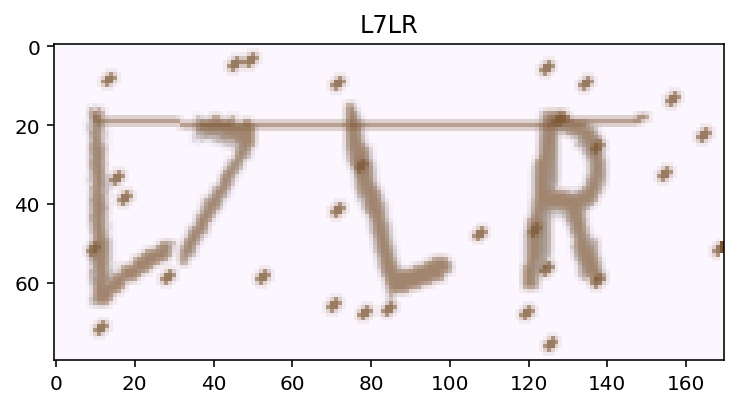

In [5]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
##驗證碼包含0-10數字以及26個英文字母
characters = string.digits + string.ascii_uppercase
print(characters)

##設定產生圖片尺寸，以及總類別，n_class之所以要加一是為了留一個位置給Blank
width, height, n_len, n_class = 170, 80, 4, len(characters)+1

##設定產生驗證碼的generator
generator = ImageCaptcha(width=width, height=height)

##我們先練習固定長度4個字的驗證碼
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

In [11]:
from keras import backend as K
import keras

##CTC Loss需要四個資訊，分別是
## Label
## 預測
## CNN OUTPUT寬度
## 預測影像所包含文字長度
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

## 自己搭建一個CNN模型使得output feature Map 高度被壓縮成小於4，8<寬度<20
#### 解答的output feature Map 為 (batch_size,1,13,32)

In [12]:
from keras.models import *
from keras.layers import *
import keras
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor

'''自己設計CNN層'''
model=keras.applications.ResNet50(include_top=False, weights='imagenet',
                                    input_tensor=input_tensor,
                                    pooling=None, classes=10)

x = model.output


#x = Flatten()(x)




##記錄輸出CNN尺寸，loss部分需要這個資訊
##conv_shape=(Batch_size,輸出高度,輸出寬度,輸出深度)
conv_shape = x.get_shape()

##從(Batch_size,輸出高度,輸出寬度,輸出深度)變成(Batch_size,輸出寬度,輸出深度*輸出高度)，以符合ctc loss需求
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(512, activation='relu')(x)

x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax')(x)


##包裝用來預測的model
base_model = Model(input=input_tensor, output=x)


##設定要給CTC Loss的資訊
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

##這裡的model是用來計算loss
model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])

##之所以要lambda y_true, y_pred: y_pred是因為我們的loss已經包在網路裡，會output:y_true, y_pred，而我們只需要y_pred
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='SGD')

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 78, 168, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 78, 168, 32)  128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 76, 166, 32)  9248        batch_normalization_9[0][0]      
__________________________________________________________________________________________________
batch_norm

In [16]:
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = True

In [17]:
##設計generator產生training data
## 產生包含要給loss的資訊
## X=輸入影像
## np.ones(batch_size)*int(conv_shape[2])=CNN輸出feature Map寬度
## np.ones(batch_size)*n_len=字串長度(可浮動)

def gen(batch_size=128):
    X = np.zeros((batch_size,height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str))
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y,np.ones(batch_size)*int(conv_shape[2]), np.ones(batch_size)*n_len], np.ones(batch_size)

Label:  [[22 18  1 33]]
CNN輸出寬度:  [6.]
字串長度(可浮動):  [4.]


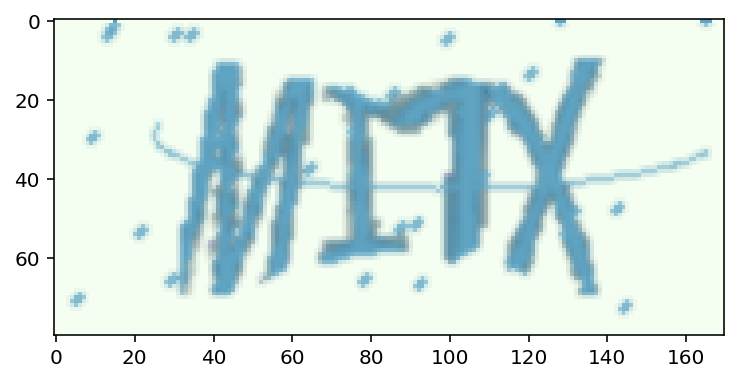

In [18]:
next_ge=gen(batch_size=1)
test_ge=next(next_ge)
plt.imshow(test_ge[0][0][0])
print('Label: ',test_ge[0][1])
print('CNN輸出寬度: ',test_ge[0][2])
print('字串長度(可浮動): ',test_ge[0][3])

## 開始訓練

In [ ]:
model.fit_generator(gen(32), steps_per_epoch=300, epochs=10)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/10
300/300 [==============================] - 37s 123ms/step - loss: 1.4981
Epoch 2/10
300/300 [==============================] - 38s 126ms/step - loss: 1.1726
Epoch 3/10
300/300 [==============================] - 39s 131ms/step - loss: 0.9719
Epoch 4/10
300/300 [==============================] - 40s 134ms/step - loss: 0.8644
Epoch 5/10
300/300 [==============================] - 40s 135ms/step - loss: inf
Epoch 6/10
300/300 [==============================] - 41s 136ms/step - loss: inf
Epoch 7/10
300/300 [==============================] - 41s 137ms/step - loss: 0.6027
Epoch 8/10
300/300 [==============================] - 41s 138ms/step - loss: 0.5400
Epoch 9/10
300/300 [==============================] - 42s 139ms/step - loss: inf
Epoch 10/10
 88/300 [=======>......................] - ETA: 29s - loss: 0.5007

## 預測

In [ ]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
##用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]

## 自己寫 decode CTC

In [53]:
## 其中0代表預測為空格，如果預測相同字符之間沒有空格要移除
word=''
n=''
for single_result in y_pred[0].argmax(1):
    if single_result != 36:
        if n != single_result:
            word+=characters[single_result]
    n=single_result 

## 額外參考：加入RNN的神經網路

In [37]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    if i <3:
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = MaxPooling2D(pool_size=(2, 1))(x)


conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru1_b')(x)
gru1_merged = keras.layers.add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru2_b')(gru1_merged)
x = keras.layers.Concatenate()([gru_2, gru_2b])

x = Dropout(0.25)(x)
x = Dense(n_class, init='he_normal', activation='softmax')(x)

base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='Adam')

/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, name="gru1", kernel_initializer="he_normal")`
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, go_backwards=True, name="gru1_b", kernel_initializer="he_normal")`
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 78, 168, 32)  896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 78, 168, 32)  128         conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 76, 166, 32)  9248        batch_normalization_25[0][0]     
__________________________________________________________________________________________________
batch_norm